In [ ]:
! pip install kaggle
! mkdir ~/.kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download scribbless/another-anime-face-dataset

100% 1.44G/1.44G [00:13<00:00, 79.7MB/s]
100% 1.44G/1.44G [00:13<00:00, 114MB/s] 


In [ ]:
! kaggle datasets download arnrob/celeba-small-images-dataset

 99% 317M/319M [00:05<00:00, 111MB/s] 
100% 319M/319M [00:05<00:00, 63.2MB/s]


In [ ]:
! unzip celeba-small-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: validation/177638.jpg   
  inflating: validation/177639.jpg   
  inflating: validation/177640.jpg   
  inflating: validation/177641.jpg   
  inflating: validation/177642.jpg   
  inflating: validation/177643.jpg   
  inflating: validation/177644.jpg   
  inflating: validation/177645.jpg   
  inflating: validation/177646.jpg   
  inflating: validation/177647.jpg   
  inflating: validation/177648.jpg   
  inflating: validation/177649.jpg   
  inflating: validation/177650.jpg   
  inflating: validation/177651.jpg   
  inflating: validation/177652.jpg   
  inflating: validation/177653.jpg   
  inflating: validation/177654.jpg   
  inflating: validation/177655.jpg   
  inflating: validation/177656.jpg   
  inflating: validation/177657.jpg   
  inflating: validation/177658.jpg   
  inflating: validation/177659.jpg   
  inflating: validation/177660.jpg   
  inflating: validation/177661.jpg   
  inflating: validation/177662.jpg   

In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
import tensorflow as tf
import keras

import numpy as np
import json
import os
import pickle

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-and0e50g
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-and0e50g
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101076 sha256=8bdca394940854cd1e54e74b11f6d3eecd50fbcd0cc298e8d265906977bbbdfc
  Stored in directory: /tmp/pip-ephem-wheel-cache-8qkakarp/wheels/67/d2/f4/96ae3c3c62d1e05abfc8860ad0c1207794726d44ebbbb547f3
Successfully built keras-contrib


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras, einsum
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras import Model, Sequential
import tensorflow.keras.layers as nn
from einops import rearrange
from einops.layers.tensorflow import Rearrange

In [ ]:
import cv2
import glob

H = 32
W = 32
batch_size = 32
def process_data(data_path):
  images = [name for name in glob.glob(data_path+'/*.jpg')]
  images = sorted(images)
  return images

def load_data(path):
  x = process_data(path)
  data_len = len(x)
  train_x = []
  for i in range(batch_size):
    rng = np.random.randint(len(x), size = 1)[0]
    #print(rng)
    train_x.append(read_img(x[rng]))
  train_x = np.array(train_x)
  return train_x

def data_length(path):
  x = process_data(path)
  return len(x)

def read_img(x):
  x = cv2.imread(x, cv2.IMREAD_COLOR)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
  x = cv2.resize(x, (W, H))
  x = (x / 127.5) - 1
  x = x.astype(np.float32)
  return x

In [ ]:
path1 = 'animefaces256cleaner'
path = 'training'
_img = load_data(path)

In [ ]:
timesteps = 200

# create a fixed beta schedule
beta = np.linspace(0.0001, 0.02, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return tf.random.uniform(shape=[num], minval=0, maxval=timesteps, dtype=tf.int32)
    

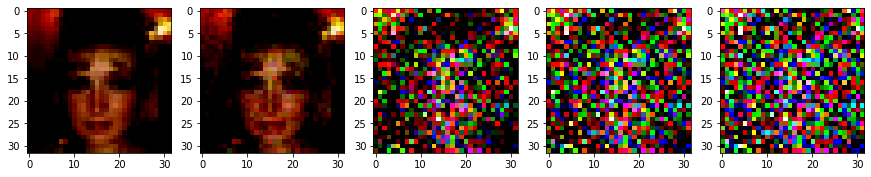

In [ ]:
#sample_mnist = next(iter(img_))[0]
sample_mnist = _img[5]

fig = plt.figure(figsize=(15, 30))

for index, i in enumerate([0, 10, 100, 150, 199]):
    noisy_im, noise = forward_noise(0, np.expand_dims(sample_mnist, 0), np.array([i,]))
    plt.subplot(1, 5, index+1)
    plt.imshow(np.squeeze(noisy_im), cmap='gray')
    

plt.show()

In [ ]:
class SinusoidalPosEmb(layers.Layer):
    def __init__(self, dim, max_positions=10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training=True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

        return emb

In [ ]:
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [ ]:
class SiLU(layers.Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training=True):
        return x * tf.nn.sigmoid(x)

def gelu(x, approximate=False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(layers.Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        return gelu(x, self.approximate)

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
class LinearAttention(tf.keras.layers.Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False)

        self.to_out = Sequential([
            nn.Conv2D(filters=dim, kernel_size=1, strides=1),
            tf.keras.layers.LayerNormalization()
        ])

    def call(self, x, training=True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)

        q = tf.nn.softmax(q, axis=-2)
        k = tf.nn.softmax(k, axis=-1)

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h=self.heads, x=h, y=w)
        out = self.to_out(out, training=training)

        return out

In [ ]:
def residual(layer_input, filters):
  shortcut = layer_input
  y = ReflectionPadding2D(padding =(1,1))(layer_input)
  y = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='valid')(y)
  y = InstanceNormalization(axis = -1, center = False, scale = False)(y)
  y = Activation('relu')(y)
            
  y = ReflectionPadding2D(padding =(1,1))(y)
  y = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='valid')(y)
  y = InstanceNormalization(axis = -1, center = False, scale = False)(y)


In [ ]:
dim = 64
time_dim = dim * 2
def _emb(dim_out):
  time_emb_model = Sequential([
            SinusoidalPosEmb(dim),
            nn.Dense(units=dim_out),
            
            nn.Dense(units=dim_out)
        ])
  return time_emb_model
def mlp(dim_out):
  mlp = Sequential([
            SiLU(),
            nn.Dense(units=dim_out * 2)
        ]) 
  return mlp

In [ ]:
silu = SiLU()
gelu = GELU()


In [ ]:
def conv_block(inputs, filters, pool=True):
      x = Conv2D(filters, 3, padding="same")(inputs)
      x = BatchNormalization()(x)
      x = Activation("relu")(x)

      x = Conv2D(filters, 3, padding="same")(x)
      x = BatchNormalization()(x)
      x = Activation("relu")(x)

      if pool == True:
          p = MaxPool2D((2, 2))(x)
          return x, p
      else:
          return x
def conv_unet(shape, num_classes):
      input1 = Input(shape)
      input2 = Input(shape = (1,))
      #print(input2)
      """ Encoder """
      x1, p1 = conv_block(input1, 16, pool=True)
      gsa = GlobalSelfAttention(num_heads=3, key_dim=64)
      print(x1.shape)
      emb = _emb(128)
      time_emb = emb(input2)
      time_emb = mlp(p1.shape[-1])(time_emb)
      time_emb = rearrange(time_emb, 'b h c -> b h 1 c')
      gamma_beta = tf.split(time_emb, num_or_size_splits=2, axis=-1)
      gamma, beta = gamma_beta
      p1 = p1 * (gamma + 1) + beta
      p1 = silu(p1)
      x1 = x1 * (gamma + 1) + beta
      x1 = silu(x1)
      x1 = gsa(x1)
      p1 = gsa(p1)
      #print(p1.shape)

      x2, p2 = conv_block(p1, 32, pool=True)
      #p2 = p2 * (gamma + 1) + beta
      #p2 = silu(p2)

      x3, p3 = conv_block(p2, 48, pool=True)
      #p3 = p3 * (gamma + 1) + beta
      #p3 = silu(p3)

      x4, p4 = conv_block(p3, 64, pool=True)
      #p4 = p4 * (gamma + 1) + beta
      #p4 = silu(p4)

      """ Bridge """
      b1 = conv_block(p4, 128, pool=False)

      """ Decoder """
      u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
      c1 = Concatenate()([u1, x4])
      x5 = conv_block(c1, 64, pool=False)

      u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
      c2 = Concatenate()([u2, x3])
      x6 = conv_block(c2, 48, pool=False)

      u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
      c3 = Concatenate()([u3, x2])
      x7 = conv_block(c3, 32, pool=False)

      u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
      c4 = Concatenate()([u4, x1])
      x8 = conv_block(c4, 16, pool=False)

      """ Output layer """
      output = Conv2D(num_classes, 1, padding="same", activation = 'tanh')(x8)

      return Model([input1, input2], output)

In [ ]:
def loss_fn(real, generated):
    loss = tf.math.reduce_mean((real - generated) ** 2)
    return loss

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
shape = (32, 32, 3)
channel = 3
model = conv_unet(shape, channel)

def train_step(batch):
    rng, tsrng = np.random.randint(0, 100000, size=(2,))
    timestep_values = generate_timestamp(tsrng, batch.shape[0])

    noised_image, noise = forward_noise(rng, batch, timestep_values)
    with tf.GradientTape() as tape:
        prediction = model([noised_image, timestep_values])
        
        loss_value = loss_fn(noise, prediction)
    
    gradients = tape.gradient(loss_value, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))

    return loss_value

(None, 32, 32, 16)


In [ ]:
! unzip checkpoints.zip

Archive:  diffusion3.zip
   creating: content/diffusion3/
   creating: content/diffusion3/assets/
  inflating: content/diffusion3/saved_model.pb  
   creating: content/diffusion3/variables/
  inflating: content/diffusion3/variables/variables.index  
  inflating: content/diffusion3/variables/variables.data-00000-of-00001  
  inflating: content/diffusion3/keras_metadata.pb  


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/content/checkpoints')

In [ ]:
def show_img(img):
  plt.imshow(img)
  return plt.show()  

In [ ]:
def ddim(x_t, pred_noise, t, sigma_t):
    alpha_t_bar = np.take(alpha_bar, t)
    alpha_t_minus_one = np.take(alpha, t-1)

    pred = (x_t - ((1 - alpha_t_bar) ** 0.5) * pred_noise)/ (alpha_t_bar ** 0.5)
    pred = (alpha_t_minus_one ** 0.5) * pred

    pred = pred + ((1 - alpha_t_minus_one - (sigma_t ** 2)) ** 0.5) * pred_noise
    eps_t = np.random.normal(size=x_t.shape)
    pred = pred+(sigma_t * eps_t)

    return pred

In [ ]:
def inference():
  inference_timesteps = 10
  timesteps = 200
  # Create a range of inference steps that the output should be sampled at
  inference_range = range(0, timesteps, timesteps // inference_timesteps)

  x = tf.random.normal((1,32,32,3))
  img_list = []
  img_list.append(np.squeeze(x))

  # Iterate over inference_timesteps
  for index, i in enumerate(reversed(range(inference_timesteps))):
    t = np.expand_dims(inference_range[i], 0)

    pred_noise = model([x, t])

    x = ddim(x, pred_noise, t, 0)
    img_list.append(np.squeeze(x))   
    


  plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8))
  return plt.show()

In [ ]:
ckpt = tf.train.Checkpoint(model)
ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=2)

# load from a previous checkpoint if it exists, else initialize the model from scratch
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    start_interation = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


5085/5086 [============================>.] - ETA: 0s - loss: 0.1960

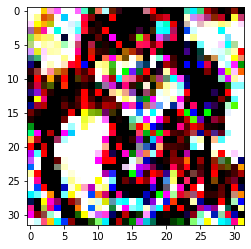

Average loss for epoch 1/50: 0.19597427546977997
  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/ckpt-1.data-00000-of-00001 (deflated 8%)
  adding: content/checkpoints/checkpoint (deflated 40%)
  adding: content/checkpoints/ckpt-1.index (deflated 76%)
  53/5086 [..............................] - ETA: 44:51 - loss: 0.2331

KeyboardInterrupt: ignored

In [ ]:
epochs = 50
data_len = data_length(path)
for e in range(1, epochs+1):
    # this is cool utility in Tensorflow that will create a nice looking progress bar
    bar = tf.keras.utils.Progbar(data_len//batch_size)
    losses = []
    for i in range(data_len//batch_size):
        # run the training loop
        loss = train_step(_img)
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])
        _img = load_data(path)
    inference()   
    avg = np.mean(losses)
    print(f"Average loss for epoch {e}/{epochs}: {avg}")
    ckpt_manager.save(checkpoint_number=e)
    !zip -r checkpoints.zip /content/checkpoints

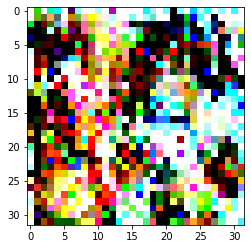

In [ ]:
inference()

In [ ]:
model.save('diffusion3/')

In [ ]:
!zip -r checkpoints.zip /content/checkpoints

In [ ]:
!zip -r diffusion3.zip /content/diffusion3

In [ ]:
import tqdm

In [ ]:
# Define number of inference loops to run
inference_timesteps = 10
timesteps = 200
# Create a range of inference steps that the output should be sampled at
inference_range = range(0, timesteps, timesteps // inference_timesteps)

x = tf.random.normal((1,64,64,3))
img_list = []
img_list.append(np.squeeze(x))

# Iterate over inference_timesteps
for index, i in enumerate(reversed(range(inference_timesteps))):
    t = np.expand_dims(inference_range[i], 0)

    pred_noise = model([x, t])

    x = ddim(x, pred_noise, t, 0)
    img_list.append(np.squeeze(x))   
    


plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8))
plt.show()

In [ ]:
tot = np.squeeze(x)
print(tot[0][0])
print()
tot = np.array(tot)
tot+=1
tot *= 127.5
tot = np.clip(tot, a_min = 0, a_max = 255)
print(tot[0][0])

In [ ]:
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

In [ ]:
x = tf.random.normal((1,64,64,3))
img_list = []
img_list.append(np.squeeze(x))

for i in range(timesteps-1):
    t = np.expand_dims(np.array(timesteps-i-1, np.int32), 0)
    pred_noise = model([x, t])
    x = ddpm(x, pred_noise, t)
    img_list.append(np.squeeze(x)) 

plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8))
plt.show()